Made by Yoonsoo P. Bach

# KMTNet Data Reduction
Because of the data protection issue, I cannot provide the data here (even if possible, the original data are as large as ~ 100 GB). What I was provided are the 2K by 2K data cropped around the target (4179) Toutatis, after
1. Image acquisition
2. Pre-processing done at KMTNet Data Center
2. WCS updated and cropped around the target (4179) Toutatis using ``MODP`` (Moving Object Detection Pipeline) by one of our co-authors (Y. JeongAhn).

If you are interested in the data reduction, please contact me via dbstn95@gmail.com, and I will ask KASI side for a permission for the data distribution. 

Thus, I will show 
1. The codes I used for the data reduction and some simple explanations
2. A snapshot of the package ``yspy``. ``yspy`` is now splitted into many sub-packages, and are planned to be distributed in the near future as citable manner via Zenodo (Y. P. Bach, 2019, in prep). We put a snapshot in this repo to guarantee a certain degree of reproducibility.
3. Few of the images of the reduced images
4. **Manual tuning of one of the images**
    * Among 9 datasets, there were two sets of interest. For one (2018-04-07 CTIO with $ \alpha = 2.79^\circ $), when Toutatis was too faint to be explained by the shape model, we could not pinpoint one single reason. For the other one (2018-04-11 SAAO with $ \alpha = 1.23^\circ $), we found there is a semi-regular pattern in the images obtained on the night at SAAO. We realized this pattern is not necessarily regular and we guess this is a result of an imperfect readout which is not easy to remove unless electronics of the CCD is fixed. Although this pattern is almost impossible to fully remove in the images, it looked quite regular in the 2018-04-11 SAAO image, just by chance. For other images, this pattern was not severe (may _systematically_ affect the fluxes within $\lesssim 0.5$-$\sigma$ error bar). Thus, we decided not to touch other results, but only for the 2018-04-11 SAAO image. We manually measured the sky value of the target (see below) and update the magnitude value. This is, however, only a temporary remedy. Same manual work should be done to each single frame and to each star. Moreover, this is not a mathematically rigorous way, but rather a very subjective decision. We currently could not find the best way to fully cure this pattern.


* **NOTE**: As mentioned above, **I will not show or distribute any raw data in this notebook**.
* **NOTE**: The codes shown here are not coded for general purpose, but to be used as *quick-and-dirty* solution for our data reduction, so please be cautious when you want to use any part of this notebook for your scientific purpose.

## Testing Environment

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, astropy, photutils, ccdproc, callhorizons, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-03-14 11:44:56 (KST = GMT+0900) 
0 Python     3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.2.0 x86_64 i386 64bit
3 scipy      1.2.0
4 numpy      1.15.4
5 matplotlib 3.0.2
6 pandas     0.24.1
7 astropy    3.1.1
8 photutils  0.6
9 ccdproc    1.3.0.post1
10 callhorizons 1.1.1
11 version_information 1.0.3


/Users/ysbach/anaconda3/lib/python3.6/site-packages/CALLHORIZONS-1.1.1-py3.6.egg/callhorizons/callhorizons.py:43: DeprecationWarning: CALLHORIZONS is not maintained anymore; please use astroquery.jplhorizons instead (https://github.com/astropy/astroquery)


The package ``callhorizons`` made by M. Mommert is available at [this GitHub repo](https://github.com/mommermi/callhorizons). It is superseded by ``astroquery``'s ``jplhorizons`` module as the above warning indicates.

## Reduction Codes

First, I imported as below:

-----
```python
import os
from pathlib import Path
from warnings import warn as W

import numpy as np
from matplotlib import pyplot as plt

from yspy.util import fits_util as fu
from yspy.util import preproc
from yspy.util.graphics import zimshow
from yspy.instruments import KMTNet
from yspy.query import astroquery_util, astrometry_client, horizons, panstarrs
from yspy.query import utils as qu
from yspy.postproc import photometry, source_find
from yspy.simulation import phase

from astropy.nddata import CCDData, Cutout2D
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, vstack, hstack
from astropy.time import Time
from astropy.convolution import Gaussian2DKernel

import ccdproc

from photutils.detection import DAOStarFinder
from photutils import CircularAnnulus as Can
from photutils import CircularAperture as Cap
from photutils.psf.groupstars import DAOGroup
```
-----

Then set the paths for your computer system:

-----
```python
# Macbook
deepsouthpath = Path('/', 'Users', 'ysbach', 'Dropbox', 'workspace', 
                     'cowork', 'KMTNet_Toutatis', 'deepsouth')
# LINUX
if not deepsouthpath.exists():
    deepsouthpath = Path('/', 'home', 'ysbach', 'Dropbox', 'workspace', 'cowork', 
                         'KMTNet_Toutatis', 'deepsouth')
    
if Path.cwd() != deepsouthpath:
    os.chdir(deepsouthpath)
    
    
crrej_dir = Path('..', "crrej_1k")
reduc_dir = Path('..', "reduc")

# We visually selected some bad images, and these images will be rejected in the codes below.
REJECT = ['20180407CTIO_p4179_016781.fits', '20180409SSO_p4179_051334.fits', 
          '20180413CTIO_p4179_018271.fits', '20180407CTIO_p4179_016782.fits', 
          '20180411SSO_p4179_051984.fits', '20180413CTIO_p4179_018272.fits',
          '20180407CTIO_p4179_016783.fits', '20180411SSO_p4179_051992.fits', 
          '20180413CTIO_p4179_018273.fits', '20180409CTIO_p4179_017408.fits', 
          '20180411SSO_p4179_051993.fits', '20180413CTIO_p4179_018274.fits', 
          '20180409SSO_p4179_051333.fits', '20180413CTIO_p4179_018270.fits', 
          '20180413CTIO_p4179_018275.fits']
    
cutsize_crrej = 1000  # For CR rejection
cutsize_targ = 200    # For the target-extracted images
rejected = []
minsep_star = 10
target = '4179'

fu.mkdir(crrej_dir)
fu.mkdir(reduc_dir)

summary = fu.load_if_exists("summary.csv", loader=Table.read)

if not Path("summary.csv").exists():
    allfits = list(Path('.').glob('**/*.fits'))
    tabs = []
    summary0 = fu.make_summary(allfits, fname_option="relative",
                              keywords=KMTNet.USEFUL_HEADER_KEYS)
    summary0["date"] = summary0["file"].copy()

    for i, dt in enumerate(summary0["date"]):
        summary0["date"][i] = dt.split('/')[0]
    
    for obs in ["CTIO", "SSO", "SAAO"]:
        obscode = KMTNet.OBSERVATORY_CODE[obs]
        tab = summary0[summary0["OBSERVAT"] == obs]
        epochs = Time(tab["DATE-OBS"]).jd
        q = horizons.DiscreteEpochQuery(target, obscode, epochs)
        q.query()
        qt = q.query_table['RA', 'DEC', 'RA_rate', 'DEC_rate', 
                           "RA_3sigma", "DEC_3sigma", 'V', 'r', 'r_rate',
                           'delta', 'delta_rate', 'lighttime', 'alpha',
                           'ObsEclLon', 'ObsEclLat']
        qt["RA"].name="RA_deg"
        qt["DEC"].name="DEC_deg"
        
        tabs.append(hstack([tab, qt]))
        
    summary = vstack(tabs)
    summary.write("summary.csv")

grouped = summary.group_by("date")
```
-----

Then for all the date-grouped images, do cosmic-ray rejection and sidereal stacking (called ``star``) and target-centered stacking (called ``targ``).

-----
```python
for group in grouped.groups:
    ccds_star = []
    ccds_targ = []
    asts = []
    uts = []
    wcs_ref = None
    starpath = reduc_dir / (group["date"][0] + '_star.fits')
    targpath = reduc_dir / (group["date"][0] + '_targ.fits')
    
#    if not starpath.exists() or not targpath.exists():
    for i, row in enumerate(group):
        fpath = Path(row["file"])
        astpath = fpath.parent / (fpath.name[:-4] + 'ast')
        pngpath = crrej_dir / (fpath.parts[-2] + '_' + fpath.name[:-4] + 'png')
        crpath = crrej_dir / (fpath.parts[-2] + '_' + fpath.name)
        if crpath.name in REJECT:
            continue
        print(fpath)
        
        ast = fu.read_without_newline(astpath)
        if len(ast) != 1:
            W("Position file has {len(ast):d} contents! Only the first one will be used.")
        
        hdu_0 = fits.open(fpath)[0]
        hdr_0 = hdu_0.header
        uts.append((Time(hdr_0["DATE-OBS"], format='isot') 
                    + hdr_0["EXPTIME"] * u.s / 2).jd)
        wcs_0 = WCS(hdr_0)
        ccd_0 = CCDData(data=hdu_0.data, header=hdu_0.header, wcs=wcs_0, 
                        unit='adu')
        coord = SkyCoord(row["RA_deg"], row["DEC_deg"], unit=u.deg)
        ast_0 = coord.to_pixel(wcs = wcs_0, origin = 0)  # xy
        # origin = 0 means 0-indexing
        
        # Check whether there's nearby sidereal object.
        plt.close('all')
        ast_0_com = photometry.find_centroid_com(ccd_0, ast_0, 
                                                 cbox_size=minsep_star / 2,
                                                 csigma=0.1)
#        print("dx, dy = ", np.array(ast_0) - np.array(ast_0_com))
#        nostar = photometry.check_nostar_convolve(ccd_0,
#                                                  kernel=Gaussian2DKernel(2),
#                                                  minsep_I0=minsep_star,
#                                                  position=ast_0_com,
#                                                  size=cutsize_targ,
#                                                  mask_size=minsep_star,
#                                                  box_size=5,
#                                                  ksigma=0.8,
#                                                  border_width=5,
#                                                  show_plot=True)
#        plt.tight_layout()
#        plt.savefig(pngpath, dpi=200)
#        plt.close('all')
        
#        if nostar:
        # Crop first since CR rejection & reprojection takes long time...
        ccd_1 = preproc.cutout2trim(ccd_0, position=ast_0_com, 
                                    size=cutsize_crrej, full=False)

        if wcs_ref is None:
            wcs_ref = ccd_1.wcs

        # CR rejection
        ccd_1_cr = fu.load_if_exists(crpath, loader=fits.open, verbose=False)
        if ccd_1_cr is None:
            continue
#            ccd_1_cr = preproc.crrej_LA(ccd_1, output=crpath)
        else:
            ccd_1_cr = CCDData(data=ccd_1_cr[0].data,
                               header=ccd_1_cr[0].header,
                               wcs=WCS(ccd_1_cr[0].header),
                               unit='adu')
        
        # WCS projection
        proj = ccdproc.wcs_project(ccd_1_cr, target_wcs=wcs_ref, 
                                   target_shape=(cutsize_crrej, cutsize_crrej))
        
        # Crop around Toutatis for non-sidereal stacking\
        ast_ref = coord.to_pixel(wcs = wcs_ref, origin = 0)
        ccd_2 = preproc.cutout2trim(proj, position=ast_ref, 
                                    size=cutsize_targ, full=False)
    
        ccds_star.append(proj)
        ccds_targ.append(ccd_2)
        
        asts.append(ast_0_com)
    
#        else:
#            rejected.append(fpath)
    # Mean time is used for future query
    time_obs = Time(np.mean(uts), format='jd')
#    plt.close('all')
    comb_star = ccdproc.combine(ccds_star, method='sum')
    comb_star.header["NCOMBINE"] = len(ccds_star)
    comb_star.header["MEANTIME"] = str(time_obs.isot)
    comb_star = fu.CCDData_astype(comb_star, 'float32')
    comb_star.write(starpath, overwrite=True)
#    fig, ax = plt.subplots(1,1)
#    c = zimshow(ax, comb_star.data)
#    plt.colorbar(c)
#    plt.close('all')
    
    comb_targ = ccdproc.combine(ccds_targ, method='sum')
    comb_targ.header["NCOMBINE"] = len(ccds_targ)
    comb_targ.header["MEANTIME"] = str(time_obs.isot)
    comb_targ = fu.CCDData_astype(comb_targ, 'float32')
    comb_targ.write(targpath, overwrite=True)
#    fig, ax = plt.subplots(1,1)
#    c = zimshow(ax, comb_targ.data)
#    plt.colorbar(c)
#    plt.close('all')
```
-----

Next, do photometry. The detailed process is described in the original publication, so I will not explain much detail.

For the bad-pixels for each image (the ``reduc_dir / "badpix.csv"`` in the code below), you may use the following csv contents:

```
file,xmin,xmax,ymin,ymax
20180407CTIO_star.fits,685,835,1,210
20180407SAAO_star.fits,806,826,1,1000
20180407SSO_star.fits,401,416,1,1000
20180407SSO_star.fits,612,626,1,1000
20180409SSO_star.fits,117,130,1,1000
20180411SSO_star.fits,602,715,274,372
20180411SSO_star.fits,655,662,274,1000
20180413CTIO_star.fits,86,177,804,895
20180413CTIO_star.fits,126,133,1,803
20180413CTIO_star.fits,854,941,917,1000
20180413CTIO_star.fits,894,902,1,916
20180413SAAO_star.fits,792,801,1,1000
```



-----
```python
reduc = list(reduc_dir.glob("*.fits"))
fwhm = 4
r_ap = 1.5 * fwhm
r_in = 4 * fwhm
r_out = 6 * fwhm
crit_sep = r_out + r_ap
catalog_Vmin = 15
catalog_Vmax = 20
maskbox_size = 100
bezel_size = 100

badpix = Table.read(reduc_dir / "badpix.csv", format='ascii.csv')

targ_phots = []
star_phots = []

for fpath in reduc:
    print(fpath.name)
    ccd = fu.load_ccd(fpath)
    t_exp = ccd.header["EXPTIME"]
    t_mean = Time(ccd.header["MEANTIME"], format='isot').jd
    gain_epadu = float(ccd.header["GAIN"])
    rdnoise_e = float(ccd.header["RDNOISE"]) * np.sqrt(ccd.header["NCOMBINE"])
    avg, med, std = sigma_clipped_stats(ccd.data, sigma=3, iters=5)

    if fpath.name.endswith("_targ.fits"):
        # Query for target at mean time
        obscode = KMTNet.OBSERVATORY_CODE[fpath.name.split('_')[0][8:]]
        q = horizons.DiscreteEpochQuery(target, obscode, [t_mean])
        q.query()
        qt = q.query_table['datetime_jd', 'RA', 'DEC', 'RA_rate', 'DEC_rate', 
                           "RA_3sigma", "DEC_3sigma", 'V', 'r', 'r_rate',
                           'delta', 'delta_rate', 'lighttime', 'alpha',
                           'ObsEclLon', 'ObsEclLat']
        qt["V"].name = "V_JPL"
        qt["RA"].name = "RA_deg"
        qt["DEC"].name = "DEC_deg"
        
        errmap = fu.make_errmap(ccd, gain_epadu=gain_epadu, 
                                rdnoise_electron=rdnoise_e)
        pos = (cutsize_targ/2 + 0.5, cutsize_targ/2 + 0.5)
        pos = photometry.find_centroid_com(ccd, pos, csigma=1)
        ap = Cap(positions=pos, r=r_ap)
        an = Can(positions=pos, r_in=r_in, r_out=r_out)    
        mask = (ccd.data > med + 3 * std)
        revive_targ = np.nonzero(ap.to_mask()[0].to_image(ccd.data.shape))
        mask[revive_targ] = False
        np.save(fpath.parent / (fpath.name[:-4] + 'mask'), mask)
       
        phot = photometry.apphot_annulus(ccd, aperture=ap, annulus=an, 
                                         mask=mask, t_exposure=t_exp, 
                                         error=errmap)
        phot["file"]=fpath.name
        phot = hstack([phot, qt])
        targ_phots.append(phot)
    
    elif fpath.name.endswith("_star.fits"):
        # mask bad pixels
        mask = (ccd.data < max(med - 6 * std, 0))
        bad = badpix[badpix['file'] == fpath.name]
        if len(bad) != 0:
            for row in bad:
                sect = f"[{row['xmin']}:{row['xmax']},{row['ymin']}:{row['ymax']}]"
                pysect = fu.fitsxy2py(sect)
                mask[pysect] = True
        
        # Mask near target
        hsize = cutsize_crrej // 2
        hboxs = maskbox_size // 2
        mask[hsize - hboxs:hsize + hboxs, hsize - hboxs:hsize + hboxs] = True 
        np.save(fpath.parent / (fpath.name[:-4] + 'mask'), mask)

        errmap = fu.make_errmap(ccd, gain_epadu=gain_epadu, 
                                rdnoise_electron=rdnoise_e)
        
        # Query for PAN-STARRS        
        coord = fu.center_coord(ccd.header)
        ps = panstarrs.panstarrs_query(*coord, rad_deg=0.06, mindet=5)
        ps = ps[(ps["ng"] > 5) & (ps["gFlags"] > 0)
                & (ps["nr"] > 5) & (ps["rFlags"] > 0)]
        
        # Find only those within the image with bezel
        qt = qu.xyinFOV(ccd.header, ps, "raMean", "decMean", bezel=bezel_size)

        # Do DAOGROUP: Delete stars close to each other
        qt["x"].name = "x_0"
        qt["y"].name = "y_0"
        qt = DAOGroup(crit_separation=crit_sep)(qt).group_by("group_id")
        gid, gnum = np.unique(qt["group_id"], return_counts=True)
        gmask = gid[gnum != 1]  # group id with > 1 stars
        remove_rows = []
        for i, gid in enumerate(qt["group_id"]):
            if gid in gmask:
                remove_rows.append(i)
        qt.remove_rows(remove_rows)
        qt.remove_column("group_id")
        
        # Remove galaxy candidates
        maybe_galaxy = (ps["iMeanPSFMag"] - ps["iMeanKronMag"] > 0.05)
        ps = ps[~maybe_galaxy]        
        
        # Calculate V mag by transformation
        V, dV = qu.sdss2BV(g=qt["gMeanApMag"], r=qt["rMeanApMag"],
                           gerr=qt["gMeanApMagErr"], rerr=qt["rMeanApMagErr"])
        qt["V"] = V
        qt["dV"] = dV
        qt = qt[(qt["V"] < catalog_Vmax) & (qt["V"] > catalog_Vmin)]
        
        # Centroiding and reject if close to masked pixels
        qt["x_c"] = 0.0
        qt["y_c"] = 0.0
        qt["shift"] = 0.0
        for i, row in enumerate(qt):
            # test whether close to masked pixel
            x_0, y_0 = [row["x_0"], row["y_0"]]
            ap_i = Cap([x_0, y_0], r=r_out)   # if too many rejected, decrese r.
            ap_val = ap_i.to_mask()[0].multiply(mask.astype(int))
            n_mask = np.count_nonzero(ap_val)
            if n_mask != 0:
                x, y = np.nan, np.nan
            else:
                x, y = photometry.find_centroid_com(ccd, [x_0, y_0], csigma=1)
            qt["x_c"][i] = x
            qt["y_c"][i] = y
            qt["shift"][i] = np.sqrt((x - x_0)**2 + (y - y_0)**2)
        qt = qt[(~np.isnan(qt["x_c"])) & (~np.isnan(qt["y_c"]))]

        # Do apphot to survived stars.
        pos = (qt["x_c"], qt["y_c"])
        ap = Cap(positions=pos, r=r_ap)
        an = Can(positions=pos, r_in=r_in, r_out=r_out)
        phot = photometry.apphot_annulus(ccd, aperture=ap, annulus=an,
                                         mask=mask, t_exposure=t_exp, error=errmap)
        phot["file"]=fpath.name
        phot = hstack([phot, Table(qt.as_array())])
        star_phots.append(phot)

targ_phots_tab = vstack(targ_phots)
star_phots_tab = vstack(star_phots)
targ_phots_tab.write(reduc_dir / "phot_targ.csv")
star_phots_tab.write(reduc_dir / "phot_star.csv")
```
-----

For each of the same-night, same-observatory results, I plot the sidereal stacked image, target-centered stacked image, and linearity plot:

-----
```python
targ_phots_tab = Table.read(reduc_dir / "phot_targ.csv")
star_phots_tab = Table.read(reduc_dir / "phot_star.csv")

def colorbaring(fig, ax, im):
    cb = fig.colorbar(im, ax=ax, orientation='vertical')
    cb.ax.set_xticklabels(cb.get_ticks().astype(int), rotation=45)

def reduced_mag_time(m_std, row):
    r = row["r"][0]
    d = row["delta"][0]
    t = Time(row['datetime_jd'][0], format='jd') - row['lighttime'][0] * u.s
    return m_std - 5.0 * np.log10(r * d), t.jd

def linf(x, a=1, b=0):
    return a * x + b

from scipy.optimize import curve_fit

star_grouped = star_phots_tab.group_by('file')
targ_stdtab = []
for group in star_grouped.groups:
    fname_star = group['file'][0]
    fname_targ = fname_star[:-9] + 'targ.fits'
    fname_png = fname_star[:-9] + '.png'
    
    targ_tab = targ_phots_tab[targ_phots_tab['file']==fname_targ]
    
    mask_star = np.load(reduc_dir / (fname_star[:-4] + 'mask.npy'))
    mask_targ = np.load(reduc_dir / (fname_targ[:-4] + 'mask.npy'))
    ccd_star = fu.load_ccd(reduc_dir / fname_star)
    ccd_targ = fu.load_ccd(reduc_dir / fname_targ)
    ccd_star.data[mask_star] = np.nan
    ccd_targ.data[mask_targ] = np.nan
    
    xy_star = [group["xcenter"], group["ycenter"]]
    xy_targ = [targ_tab["xcenter"], targ_tab["ycenter"]]
    
    plt.close('all')
    fig, axs = plt.subplots(2,2, figsize=(12, 12))
    
    ax_star = axs[0, 0]
    ax_targ = axs[0, 1]
    ax_fit = axs[1, 0]
    
    # The "star" image
    im_star = zimshow(ax_star, ccd_star.data)
    ap_star = Cap(positions=xy_star, r=r_ap)
    an_star = Can(positions=xy_star, r_in=r_in, r_out=r_out)
    ap_star.plot(ax=ax_star, color='k', alpha=0.5)
    an_star.plot(ax=ax_star, color='r', alpha=0.5)
        
    # The "target" image
    im_targ = zimshow(ax_targ, ccd_targ.data)
    ap_targ = Cap(positions=xy_targ, r=r_ap)
    an_targ = Can(positions=xy_targ, r_in=r_in, r_out=r_out)
    ap_targ.plot(ax=ax_targ, color='k')
    an_targ.plot(ax=ax_targ, color='r')
    
    colorbaring(fig, ax_star, im_star)
    colorbaring(fig, ax_targ, im_targ)

    # The linearity fit    
    xx = np.linspace(catalog_Vmin-1, catalog_Vmax+4, 2)
    yerr = np.sqrt(group["merr"]**2 + group["dV"]**2)  # rough estimate
    popt, pcov = curve_fit(linf, group["V"], group["mag"], sigma=yerr,
                           absolute_sigma=True)
    a0, b0 = popt
    da, db = np.sqrt(np.diag(pcov))
    m, dm = targ_tab["mag"][0], targ_tab["merr"][0]
    
    ax_fit.errorbar(group["V"], group["mag"], group["merr"], capsize=3, ls='', 
                       marker='x', label=None)
    ax_fit.plot(xx, linf(xx, a0, b0), 'k:',
                label=(r"slope$= {:.3f} \pm {:.3f}$, "
                       + r"$V_{{zp}} = {:.3f} \pm {:.3f}$").format(a0, da, b0, db))
    
    m_std = (m - b0) / a0
    dm_std = np.sqrt( (dm / a0)**2 + (db / a0)**2 + ((m - b0)/a0**2 * da)**2)
    H, t_target = reduced_mag_time(m_std, targ_tab)
    lab_targ = (r"$V(r_h, \Delta, \alpha) = {:.3f} \pm {:.3f}$"
                + "\n" 
                + r"$V(1, 1, {:.2f}^{{\circ}})= {:.3f} \pm {:.3f}$")
    
    ax_fit.errorbar(m_std, m, xerr=dm_std, marker='*', color='r', ms=15, 
                    mfc='none',
                    label=lab_targ.format(m_std, dm_std, targ_tab["alpha"][0], 
                                          H, dm_std))
    ax_fit.set_xlim(catalog_Vmin, catalog_Vmax+1)
    ax_fit.set_ylim(catalog_Vmin+b0, catalog_Vmax+2+b0)
    ax_fit.grid()
    ax_fit.set_xlabel((r"$V$ [mag] (From PS1, "
                       + r"Lupton 2005 gr $\rightarrow$ V transformation)"))
    ax_fit.set_ylabel(r"$V_\mathrm{{inst}}$ [mag]")
    ax_fit.legend(loc=2)
    
    plt.tight_layout()
    
    plt.savefig(reduc_dir / fname_png)
    plt.close('all')

    targ_tab["m_std"] = m_std
    targ_tab["m_red"], targ_tab["merr_red"] = H, dm_std
    targ_tab["t_target"] = t_target
    targ_stdtab.append(targ_tab)
    
targ_stdtab = vstack(targ_stdtab)
targ_stdtab.write(reduc_dir / "phot_targ.csv")
```
-----

An example of the resulting plot is shown below (Siding Spring Observatory, on 2018-04-09):

![](figs/20180409SSO_.png)

* Black circles: aperture used for aperture photometry
* Red annuli: annular regions to estimate sky
* White regions (NaN pixels): where saturation/blooming occured, or the stellar pixels near the target.

As a result, I obtained the following ``phot_targ.csv`` file (you may just copy-and-paste it and save as a csv file):

```
id,xcenter,ycenter,aperture_sum,aperture_sum_err,msky,nrej,nsky,ssky,source_sum,source_sum_err,mag,merr,file,datetime_jd,RA_deg,DEC_deg,RA_rate,DEC_rate,RA_3sigma,DEC_3sigma,V_JPL,r,r_rate,delta,delta_rate,lighttime,alpha,ObsEclLon,ObsEclLat,m_std,m_red,merr_red,t_target
1,99.99826896238706,100.50631546021809,81228.67873959502,255.91276044857713,692.2071042720206,11,998,16.290871775954447,2941.8996120238444,262.47434405697203,-4.226191496508501,0.09686866846103874,20180407CTIO_targ.fits,2458215.633683866,205.85845,-10.0691,-0.009155277777777778,0.0034482916666666668,0.009,0.002,20.76,3.806683070634,4.7604286,2.81843518127849,-0.9680001,1406.4126600000002,2.7863,207.8744685,0.5951508,21.503228340750695,16.35045448078801,0.1719984166452296,2458215.6174059417
1,100.40303782933367,99.80724669423635,102775.99914360391,288.9277031429431,857.3189814781076,3,1005,20.021498903788935,5815.506639794461,297.6257997674568,-4.966090763826891,0.05556577032625354,20180407SAAO_targ.fits,2458216.405011574,205.68906,-10.00459,-0.009193888888888889,0.003468825,0.009,0.002,20.75,3.808800126846,4.744184,2.81819363840852,-0.4916773,1406.29212,2.5429,207.6956768,0.5956415,20.915617677742794,15.761822611981717,0.08933435443783663,2458216.3887350447
1,100.2878085282523,100.99861602015855,170802.85745460697,367.2786117326402,1451.058447817702,7,995,21.83494174715075,6692.013309240952,375.5296577910269,-5.118513864107845,0.06092727652844363,20180407SSO_targ.fits,2458216.028442847,205.77185,-10.03613,-0.009174944444444446,0.0034580277777777777,0.009,0.002,20.75,3.807767466496,4.7521132,2.81828827593016,-0.735526,1406.33934,2.6618,207.7830704,0.5954059,21.231171247936654,16.077892083318353,0.10455153304691477,2458216.0121657713
1,100.20665605624994,101.40262104855,83171.50572924544,266.29363539544,673.9933725940132,41,965,17.77032176326622,6944.651124501281,274.0401420729421,-5.158747956924872,0.04284380863365858,20180409CTIO_targ.fits,2458217.632635035,205.41864,-9.90146,-0.009234777777777778,0.003487088888888889,0.009,0.002,20.72,3.812154651092,4.7183545,2.81820122948009,0.1406328,1406.2959,2.155,207.4101172,0.5963184,20.793535975029588,15.637823421174996,0.09223824973234893,2458217.6163584623
1,99.79915709379121,100.59602603304214,75082.18214603269,261.8661900776252,620.7988004414439,123,883,16.443825304827968,4871.491916361629,269.24128037128196,-4.773776839612017,0.06000728543399984,20180409SSO_targ.fits,2458218.026400463,205.33161,-9.86823,-0.009248111111111111,0.0034945777777777775,0.009,0.002,20.71,3.813226749507,4.7100761,2.81830448170511,0.3727141,1406.34744,2.0303,207.3181792,0.5965186,20.633049389724587,15.476646678876229,0.09914327668597976,2458218.010123294
1,99.99989983035023,100.66391552974753,99003.26277937792,288.17647209607657,800.97166015625,4,1000,20.546478150697816,8415.502181280099,297.3978851933971,-5.367321966279652,0.03836914829530191,20180411SAAO_targ.fits,2458220.405226215,204.80418,-9.66645,-0.00930275,0.0035281555555555554,0.009,0.002,20.65,3.819663512052,4.6601303,2.81998375479874,1.7498716,1407.1854,1.277,206.7606667,0.5974695,20.283336610683,15.121978048204145,0.09840092613400866,2458220.3889393467
1,100.14854072428979,100.56932181524242,59509.78974848555,219.12869819588786,479.75074752898627,2,1006,13.279781482249115,5251.258484799655,224.18666346830057,-4.855280364701986,0.04635223686970097,20180411SSO_targ.fits,2458220.031770833,204.88716,-9.69826,-0.009297583333333333,0.0035220416666666664,0.009,0.002,20.66,3.818657536576,4.6679639,2.81960014156878,1.5108372,1406.9939399999998,1.3952,206.8484332,0.5973361,20.490131739336242,15.329640561412049,0.08618237507460365,2458220.015486181
1,100.1852531138403,100.394401420998,50513.377618852035,199.9605999334698,410.57962321942273,30,977,15.37205900261952,4077.916210139105,207.55219473747636,-4.580717619009562,0.05526031448198902,20180413CTIO_targ.fits,2458221.631400463,204.5318,-9.56199,-0.009310249999999999,0.0035330500000000003,0.009,0.002,20.62,3.822954572921,4.6344297,2.82156061051997,2.3873702,1407.97224,0.8906,206.4725259,0.5977997,20.48608785709762,15.321645250462767,0.12419296907641106,2458221.615104488
1,99.99276753806915,100.00501913411503,131999.45199560787,327.89806515177463,1088.915180536343,2,994,21.35254671353093,8846.046459614241,336.7256497898473,-5.421494913948251,0.041328658030074,20180413SAAO_targ.fits,2458222.405691771,204.3596,-9.49585,-0.009314555555555557,0.003541575,0.009,0.002,20.59,3.825023401629,4.6182159,2.82280436711817,2.8821393,1408.5928800000002,0.649,206.290274,0.5979584,20.770045464851552,15.603471078952042,0.0909828006208629,2458222.3893886125
```

To generate a TeX-like table, I used the following code:
```python
from astropy.io.ascii.latex import latexdicts
tab = Table.read(reduc_dir / "phot_targ.csv")

tab1 = dict(date=[], time=[], observatory=[], N=[])
for fpath in tab["file"]:
    hdr = fits.getheader(reduc_dir / fpath)
    N = hdr["NCOMBINE"]
    t = Time(hdr["MEANTIME"], precision=0)
    obs = hdr["OBSERVAT"]
    date = t.datetime.strftime("%Y-%m-%d")
    time = t.datetime.strftime("%H:%M:%S")
    tab1["N"].append(N)
    tab1["date"].append(date)
    tab1["time"].append(time)
    tab1["observatory"].append(obs)
tab1 = Table(tab1)
tab2 = tab[["r", "delta", "alpha", "m_std", "merr_red", "m_red"]]
tab2 = hstack([tab1, tab2])

tab2["alpha"].unit = u.deg
for c in ["r", "delta"]:
    tab2[c].format = '.4f'
    tab2[c].unit = u.au
for c in ["m_std", "merr_red", "m_red"]:
    tab2[c].format = '.3f'
    tab2[c].unit = u.mag

tab2.write("test.tex", format='ascii.latex', latexdict=latexdicts["AA"])
```

The result:
```
\begin{table}
\begin{tabular}{cccccccccc}
\hline \hline
date & time & observatory & N & r & delta & alpha & m_std & merr_red & m_red \\
 &  &  &  & $\mathrm{AU}$ & $\mathrm{AU}$ & $\mathrm{{}^{\circ}}$ & $\mathrm{mag}$ & $\mathrm{mag}$ & $\mathrm{mag}$ \\
\hline
2018-04-07 & 03:12:30 & CTIO & 7 & 3.8067 & 2.8184 & 2.7863 & 21.503 & 0.172 & 16.350 \\
2018-04-07 & 21:43:13 & SAAO & 10 & 3.8088 & 2.8182 & 2.5429 & 20.916 & 0.089 & 15.762 \\
2018-04-07 & 12:40:57 & SSO & 13 & 3.8078 & 2.8183 & 2.6618 & 21.231 & 0.105 & 16.078 \\
2018-04-09 & 03:10:59 & CTIO & 9 & 3.8122 & 2.8182 & 2.155 & 20.794 & 0.092 & 15.638 \\
2018-04-09 & 12:38:01 & SSO & 10 & 3.8132 & 2.8183 & 2.0303 & 20.633 & 0.099 & 15.477 \\
2018-04-11 & 21:43:31 & SAAO & 11 & 3.8197 & 2.8200 & 1.277 & 20.283 & 0.098 & 15.122 \\
2018-04-11 & 12:45:45 & SSO & 5 & 3.8187 & 2.8196 & 1.3952 & 20.490 & 0.086 & 15.330 \\
2018-04-13 & 03:09:13 & CTIO & 4 & 3.8230 & 2.8216 & 0.8906 & 20.486 & 0.124 & 15.322 \\
2018-04-13 & 21:44:11 & SAAO & 13 & 3.8250 & 2.8228 & 0.649 & 20.770 & 0.091 & 15.603 \\
\hline
\end{tabular}
\end{table}
```

# SDSS to V Conversion
The PS1 catalog is in SDSS filter system, so we had to convert the magnitudes into Johnson-Cousins V filter magnitude. According to SDSS, there are two possible ways for the conversion: Jester et al. (2005) & Lupton (2005) ([link](http://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php)):

* Jester: $ V = g - 0.59 (g - r) - 0.01 $ (RMS 0.01)
* Lupton: $ V = g - 0.5784 * (g - t) - 0.0038 $ (RMS 0.0054)

In the code below, I queried PS1 near one of our image (with at least 5 observations in both g and r with non-zero quality flag in g and r, and removed possible galactic sources by method described in [this link](https://outerspace.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies)). 

```python
ccd_1_cr = fits.open('../crrej_1k/20180413SAAO_p4179_010461.fits')[0]
fig, axs = plt.subplots(1,3)
coord = fu.center_coord(ccd_1_cr.header, skycoord=True)
wcs = WCS(ccd_1_cr.header)
zimshow(axs[0], ccd_1_cr.data)

test_query = panstarrs.panstarrs_query(coord.ra.value, coord.dec.value, 0.06, mindet=5)
test_query = test_query[(test_query["ng"] > 5) 
                        & (test_query["nr"] > 5)
                        & (test_query["gFlags"] > 0)
                        & (test_query["rFlags"] > 0)]
maybe_galaxy = test_query["iMeanPSFMag"] - test_query["iMeanKronMag"] > 0.05
# https://outerspace.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies

test_query = test_query[~maybe_galaxy]
axs[1].plot(test_query["gMeanPSFMag"], 
            test_query["gMeanPSFMag"] - test_query["gMeanApMag"], 
            'ro', mfc='none', label="PSF - Ap")
axs[1].plot(test_query["gMeanPSFMag"], 
            test_query["gMeanPSFMag"] - test_query["gMeanKronMag"], 
            'bo', mfc='none', label="PSF - Kron")
axs[1].plot(test_query["gMeanPSFMag"], 
            test_query["gMeanApMag"] - test_query["gMeanKronMag"], 
            'go', mfc='none', label="Ap - Kron")
axs[1].legend()
axs[1].set_xlabel("Mean PSF magnitude")
axs[1].set_title("g-band analysis")

test_query["Vmag1"] = (test_query["gMeanPSFMag"] 
                      - 0.59 * (test_query["gMeanPSFMag"] - test_query["rMeanPSFMag"]) 
                      - 0.01)
test_query["Vmag2"] = (test_query["gMeanPSFMag"] 
                      - 0.5784 * (test_query["gMeanPSFMag"] - test_query["rMeanPSFMag"]) 
                      - 0.0038)
axs[2].plot(test_query["Vmag2"], test_query["Vmag1"] - test_query["Vmag2"], 'rx')
axs[2].set_xlabel("Lupton V mag")
axs[2].set_ylabel("Jester - Lupton V mag")
# Use of Vmag1 (2) will systematically decrease (increase) the magnitude of our 
# target by 0.13 mag.
# Jester et al. (2005) & Lupton (2005)
# http://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php

#for row in test_query:
#    variable = str(bin(row["objInfoFlag"]))[-9]
#    print(variable)
    
# Test if within [+30:-30, +30:-30] region
# Test if within V_JPL +- 5 mag

query_xy = wcs.wcs_world2pix(test_query["raMean"], test_query["decMean"], 0)
axs[0].plot(*query_xy, 'ro', mfc='none')
for i in range(len(query_xy[0])):
    V = test_query["Vmag2"][i]
    if V > 17 and V < 20:
        axs[0].text(query_xy[0][i], query_xy[1][i], "{:.1f}".format(V), 
           color='k', fontweight="bold")
    else:
        axs[0].text(query_xy[0][i], query_xy[1][i], "{:.1f}".format(V), 
           color='orange', fontweight="bold")

plt.tight_layout()
```

The resulting image is like this:
![](figs/SDSS2V_Conversion.png)

* *left*: The black numbers are the stars with 17 < V < 20 mag. In our photometry, we used stars that have 15 < V < 20 mag.
* *middle*: Comparison of gmag values from PS1 (Ap = aperture, PSF = point-spread function, Kron = Kron radius photometry).
* *right*: Comparison of two possible SDSS-to-V conversions.

Note the systematic offsets between 
1. (PSF and Ap mag) and Kron mag 
  * The dispersion of data points gets larger when PSF mag $ \gtrsim 20 $ mag. We used PSF mag throughout our work.
2. Jester and Lupton conversions. 
  * The conversion used PSF mag. You can see Jester and Lupton conversion has systematic offset of ~ 0.015 mag (~ 1.5 % of the flux), regardless of the type of the point sources.

In the publication, we used Lupton's conversion formula.

## Remedy of 2018-04-11 SAAO

As in the figure below, the target is severely affected by the seim-regular pattern:
![](figs/20180411SAAO_.png)

This is not because of wrong WCS projection nor sky pattern, but is (as far as we guess) due to the unknown fluctuation in the electronics, such as substrate voltage. Somehow a strong component of this fluctuation has period of nearly an integer times the readout time for one horizontal line, and thus showing horizontal pattern.

We manually checked how different the sky value along the horizontal direction is compared to the circular annulus analysis. Then we found the target flux is systematically overestimated about $ \sim 10\% $ due to the misleading sky measurement:

![](figs/ds9_screenshot.png)

Thus, we decided to manually tune at least this 2018-04-11 SAAO data. A more detailed look at the sky levels:

SExtractor mode estimation is used. 
l = left sky, r = right sky, a = all sky
     mode     avg      med      std
l, 810.093, 806.376, 807.863, 17.779
r, 809.446, 810.138, 809.861, 18.706
a, 810.499, 808.185, 809.111, 18.278


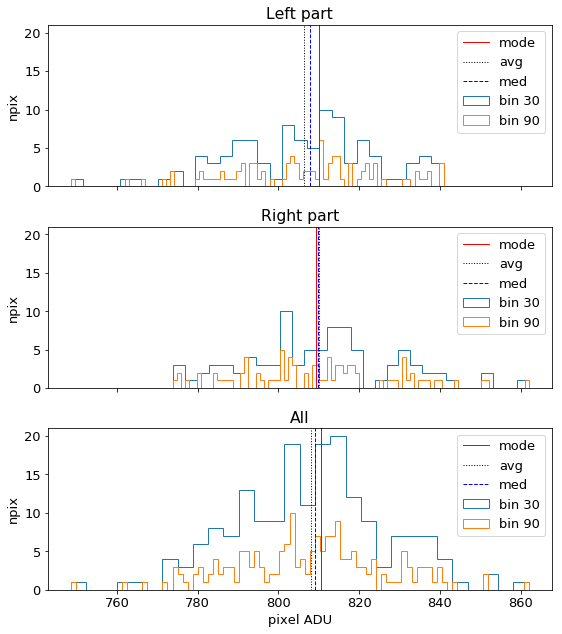

In [7]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams

from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

rcParams.update({'font.size':13})

fwhm = 4
r_ap = 1.5 * fwhm
r_in = 4 * fwhm
fpath = Path("data") / "20180411SAAO_targ.fits"
hdu = fits.open(fpath)[0]
data = hdu.data
EXPTIME = hdu.header["EXPTIME"]
center = [100.0, 100.663916]  # x, y

x_los = [round(center[0] - r_in - fwhm),
         round(center[0] + r_in - fwhm)]
x_his = [round(center[0] - r_in + fwhm),
         round(center[0] + r_in + fwhm)]

y_los = [round(center[1] - r_ap),
         round(center[1] - r_ap)]
y_his = [round(center[1] + r_ap),
         round(center[0] + r_ap)]

skys = dict(l=[], r=[])
allsky = []

print("SExtractor mode estimation is used. ")
print("l = left sky, r = right sky, a = all sky")
print("     mode     avg      med      std")

fig, axs = plt.subplots(3, 1, figsize=(8, 9), sharex=True, sharey=True, gridspec_kw=None)
axs[0].set_title("Left part")
axs[1].set_title("Right part")
axs[2].set_title("All")

for i, (side, arr) in enumerate(skys.items()):
    skydata = data[y_los[i]:y_his[i], x_los[i]:x_his[i]]
    allsky.append(skydata.flatten())
    avg, med, std = sigma_clipped_stats(skydata, std_ddof=1)
    if (avg - med) / std > 0.3:
        msky = med
    else:
        msky = 2.5 * med - 1.5 * avg

    for item in [skydata, avg, med, std, msky]:
        arr.append(item)

    print(f"{side}, {msky:.3f}, {avg:.3f}, {med:.3f}, {std:.3f}")
    axs[i].hist(skydata.flatten(), bins=30, histtype='step', label="bin 30")
    axs[i].hist(skydata.flatten(), bins=90, histtype='step', label="bin 90")
    axs[i].axvline(msky, color='r', ls='-', lw=1, label='mode')
    axs[i].axvline(avg, color='k', ls=':', lw=1, label='avg')
    axs[i].axvline(med, color='b', ls='--', lw=1, label='med')
    axs[i].legend(loc=1)
    axs[i].set_ylabel("npix")

# Do same thing for the combined sky array. Use it as if it is the real sky.
allsky = np.hstack(allsky)
clipped = sigma_clip(allsky)
nsky = allsky.shape[0]
nrej = np.count_nonzero(clipped.mask)
avg, med, std = sigma_clipped_stats(allsky, std_ddof=1)
if (avg - med) / std > 0.3:
    msky = med
else:
    msky = 2.5 * med - 1.5 * avg

axs[2].hist(allsky, bins=30, histtype='step', label="bin 30")
axs[2].hist(allsky, bins=90, histtype='step', label="bin 90")
axs[2].axvline(msky, color='r', ls='-', lw=1, label='mode')
axs[2].axvline(avg, color='k', ls=':', lw=1, label='avg')
axs[2].axvline(med, color='b', ls='--', lw=1, label='med')
axs[2].legend(loc=1)
axs[2].set_xlabel("pixel ADU")
axs[2].set_ylabel("npix")
print(f"a, {msky:.3f}, {avg:.3f}, {med:.3f}, {std:.3f}")

plt.tight_layout()
plt.show()

Now, use the sky statistics obtained from all the sky regions as the usual sky statistics. Just crudely update the original ``phot_targ_4latex.csv`` to ``phot_targ_4latex_new.csv``:

In [4]:
from astropy.table import Table

phot_targ = Table.read(Path("data") / "phot_targ_4latex.csv")
phot_new = phot_targ.copy()
row = phot_targ[phot_targ["file"]=="20180411SAAO_targ.fits"]

n_ap = np.pi * r_ap**2
source_sum = row["aperture_sum"] - msky * n_ap
source_sum_err = np.sqrt(row["aperture_sum_err"]**2 + n_ap**2 * std**2 / nsky)
mag = -2.5 * np.log10(source_sum / EXPTIME)
merr = (2.5 / np.log(10)) * source_sum_err / source_sum
dm = mag - row["mag"]
m_std = row["m_std"] + dm
m_red = row["m_red"] + dm
merr_red = np.sqrt(row["merr_red"]**2 - row["merr"]**2 + merr**2)
maps = dict(msky=msky, nrej=nrej, nsky=nsky, ssky=std, 
            source_sum=source_sum, source_sum_err=source_sum_err,
            mag=mag, merr=merr, m_std=m_std, m_red=m_red, merr_red=merr_red)

idx_new = np.argwhere(phot_new["file"]=="20180411SAAO_targ.fits")[0]
for k, v in maps.items():
    phot_new[k][idx_new] = v

phot_new.write(Path("data") / "phot_targ_4latex_new.csv")